In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from functools import reduce
from matplotlib import ticker

/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
raw_data = pd.read_csv('Data/saveData_SYTYCG_Season1.csv', index_col=0)

# calculate stats for each grapdhNum-group pairing
grp = raw_data.groupby(['graphNum', 'group']).agg({'val':['mean', 'max', 'min', 'std', stats.sem]})
grp.columns = ['mean', 'max', 'min', 'std', 'sem']
grp.reset_index(inplace=True)

# compute mean +/- 1 SD
grp['minus_1sd'] = grp['mean'] - grp['std']
grp['plus_1sd'] = grp['mean'] + grp['std']

In [3]:
grp.head()

,graphNum,group,mean,max,min,std,sem,minus_1sd,plus_1sd
0,1,Massed,49.405409,72.532618,24.502193,10.573517,1.182155,38.831892,59.978926
1,1,Spaced,49.470607,75.328566,20.214514,11.061478,1.236711,38.409129,60.532084
2,2,Massed,49.581068,74.941091,28.288028,8.331347,0.931473,41.249721,57.912414
3,2,Spaced,49.429959,74.053940,23.970771,9.816830,1.097555,39.613129,59.246789
4,3,Massed,48.395230,71.979325,20.178931,9.849317,1.101187,38.545913,58.244547


In [4]:
def sd_pooled(sds):
    return reduce(lambda x, y: np.sqrt(x**2 + y**2) / 2, sds)

grp2 = grp.groupby(['graphNum']).agg({'std': sd_pooled, 'mean': np.diff})
grp2.reset_index(inplace=True)
grp2['cohens_d'] = np.abs(grp2['mean'] / grp2['std'])

def assign_color(cohens_d):
    if cohens_d <= 0.1:
        color_m = 'cornflowerblue'
    elif cohens_d <= 0.5:
        color_m = 'turquoise'
    elif cohens_d <= 0.8:
        color_m = 'limegreen'
    elif cohens_d > 1:
        color_m = 'orange'
    
    return color_m

grp2['color'] = grp2['cohens_d'].apply(lambda x: assign_color(x))
grp2.head()

,graphNum,std,mean,cohens_d,color
0,1,7.651071,0.065197,0.008521,cornflowerblue
1,2,6.437808,-0.151109,0.023472,cornflowerblue
2,3,7.029475,0.491013,0.069851,cornflowerblue
3,4,7.213636,0.503252,0.069764,cornflowerblue
4,5,6.781659,-0.360394,0.053142,cornflowerblue


In [5]:
label_fs = 12
tick_fs = 10
my_dpi = 196
ms = 12
cs = 6

In [6]:
def plot_group(n):
    '''Plots data for group n'''
    
    plt.figure(figsize=(600/my_dpi, 600/my_dpi), dpi=my_dpi)
    data_m = grp.loc[2*(n-1)]
    data_s = grp.loc[2*(n-1) + 1]
    graph_data = grp2[grp2['graphNum'] == n]
    cohens_d = graph_data['cohens_d'].values[0]
    color_m = graph_data['color'].values[0]
    filename = 'Frederick' + str(n) + '.jpg' #.bmp is not supported by matplotlib
    
    plt.errorbar(x=1, y=data_m['mean'], yerr=data_m['sem'], fmt='ro', markersize=ms, mfc=color_m, mec=color_m,
                 capsize=cs, ecolor='black', barsabove=True)
    plt.errorbar(x=2, y=data_s['mean'], yerr=data_s['sem'], fmt='bo', markersize=ms, 
                 capsize=cs, ecolor='black', barsabove=True)
    
    ax = plt.gca()
    
    ymin = np.mean([data_m['minus_1sd'], data_s['minus_1sd']])
    ymax = np.mean([data_m['plus_1sd'], data_s['plus_1sd']])
    plt.ylim(ymin, ymax)

    if ymin % 5 < 1:
        tick_start = (ymin // 5) * 5
    else:
        tick_start = (ymin // 5 + 1) * 5

    if ymax % 5 > 4:
        tick_end = ymax + 5
    else:
        tick_end = ymax
        
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.yaxis.set_ticks(np.arange(tick_start, tick_end, 5))
    plt.yticks(fontsize=tick_fs)
    
    plt.xlim(0.5,2.5)
    plt.xticks([1,2], ['Massed', 'Spaced'], fontsize=tick_fs)
    plt.tick_params(bottom=False)     
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.xlabel('Study Style', fontsize=label_fs, fontweight='bold')
    plt.ylabel('Final Exam Score', fontsize=label_fs, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, transparent=True)

/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


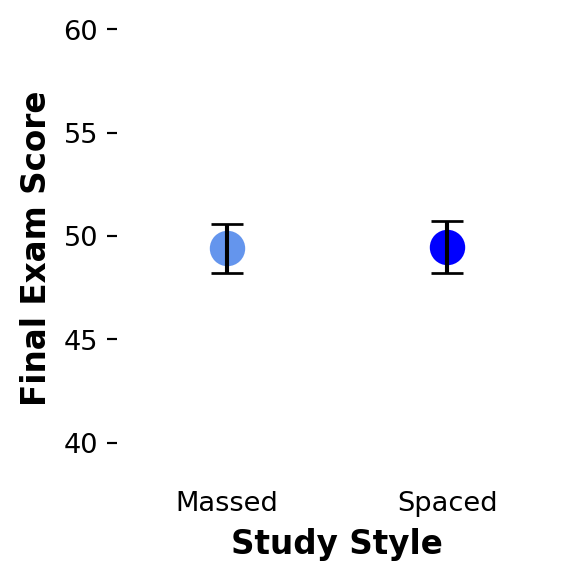

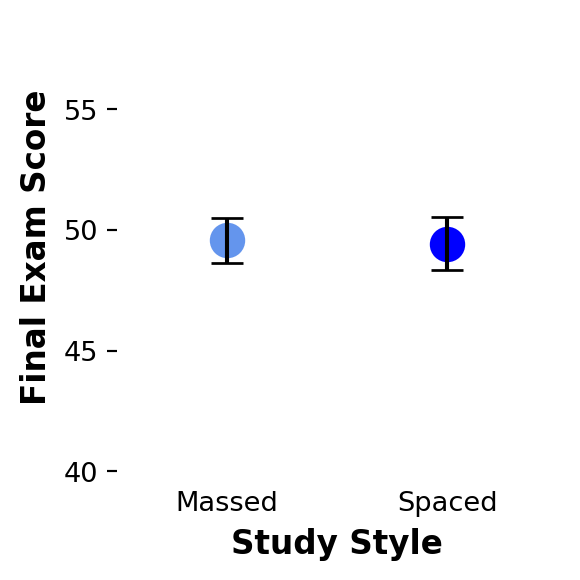

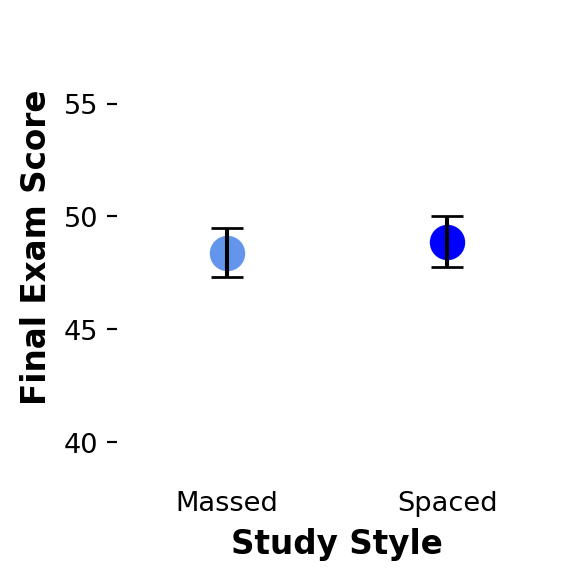

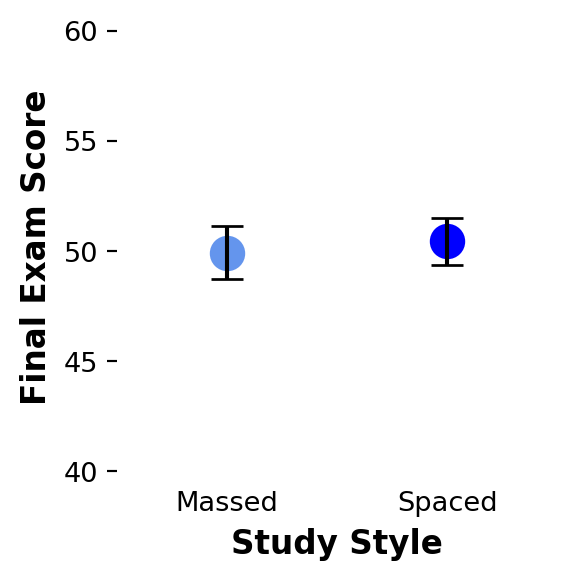

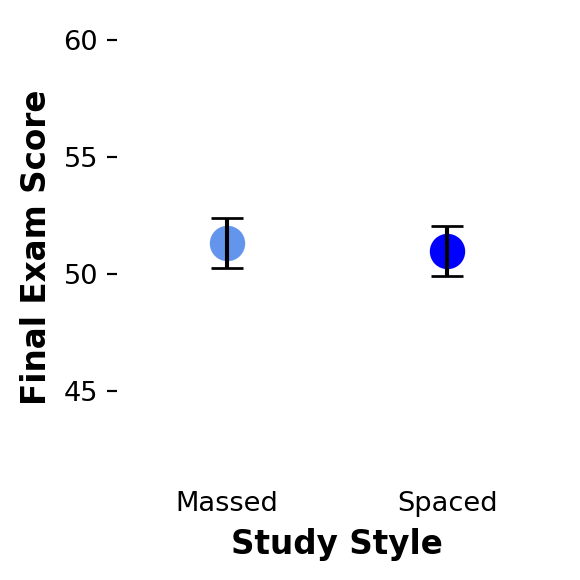

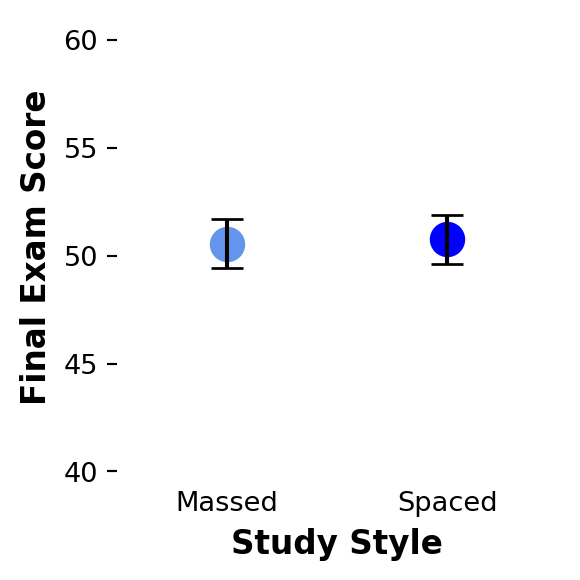

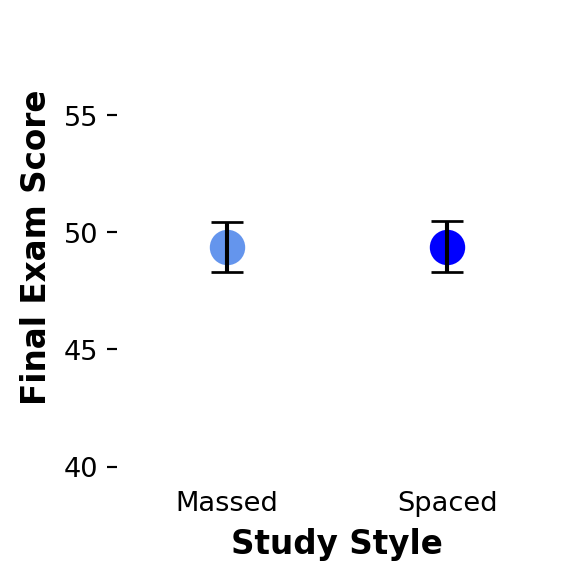

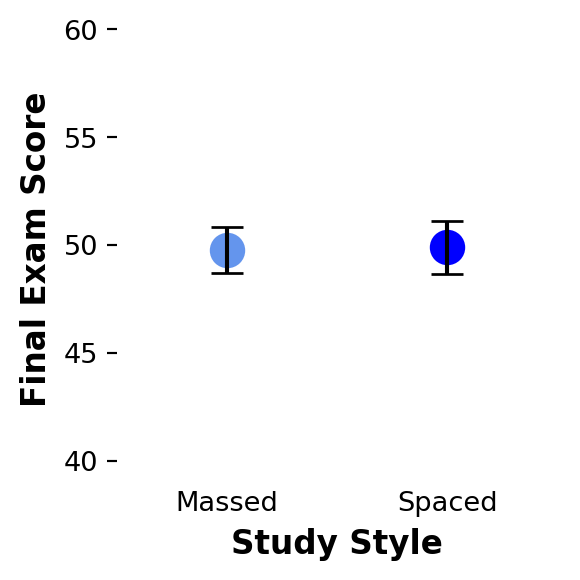

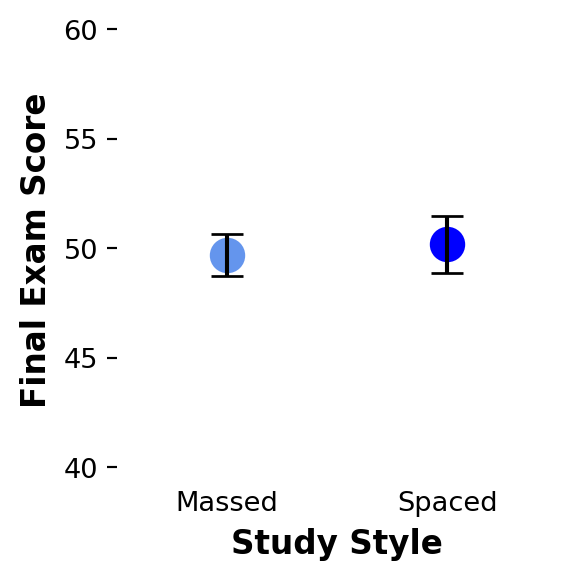

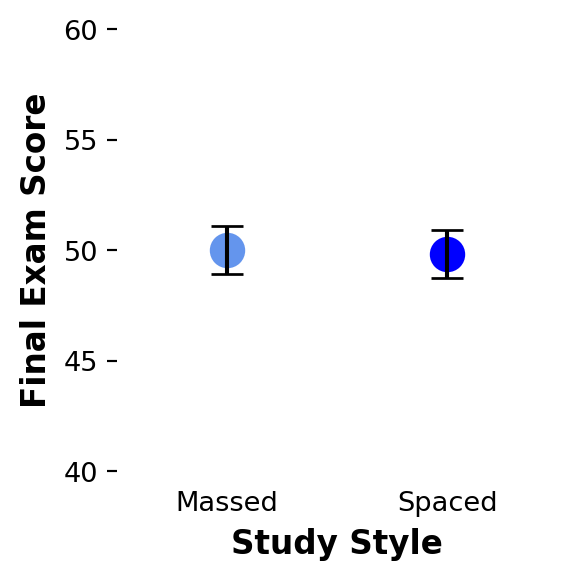

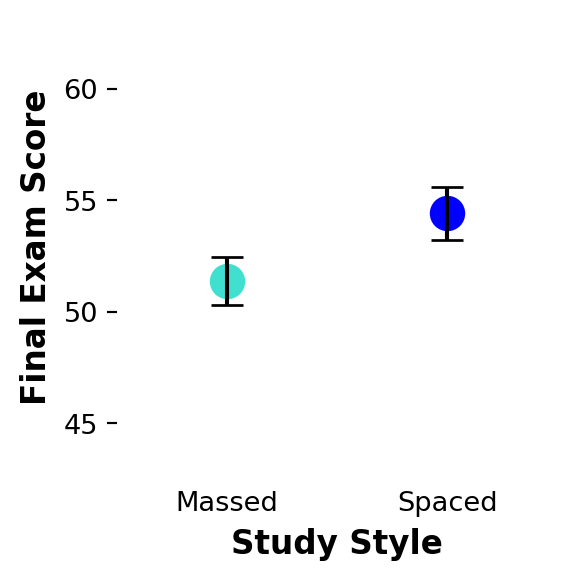

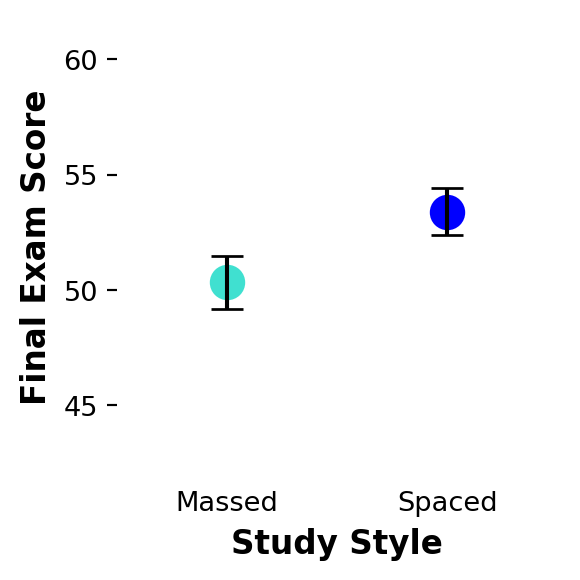

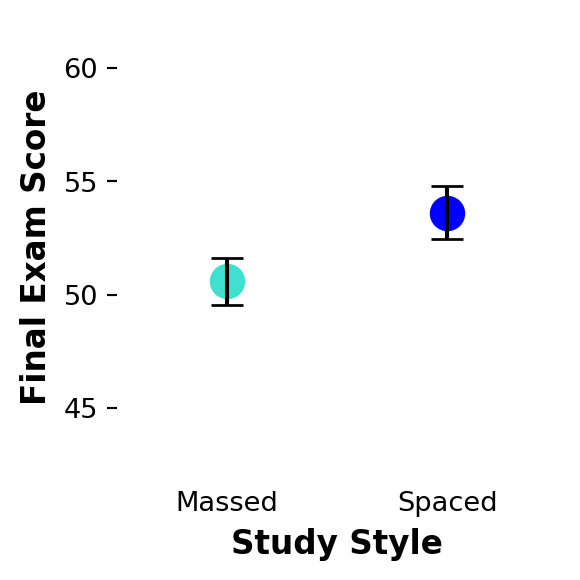

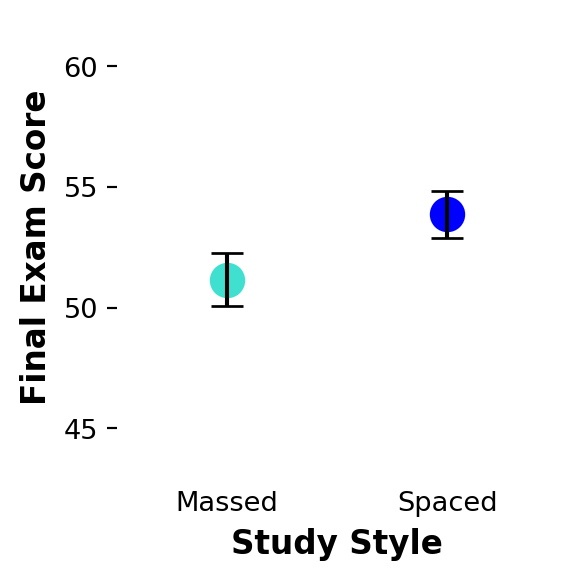

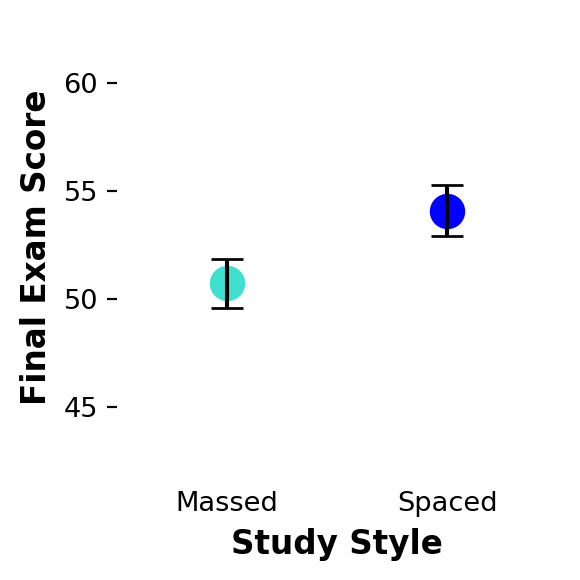

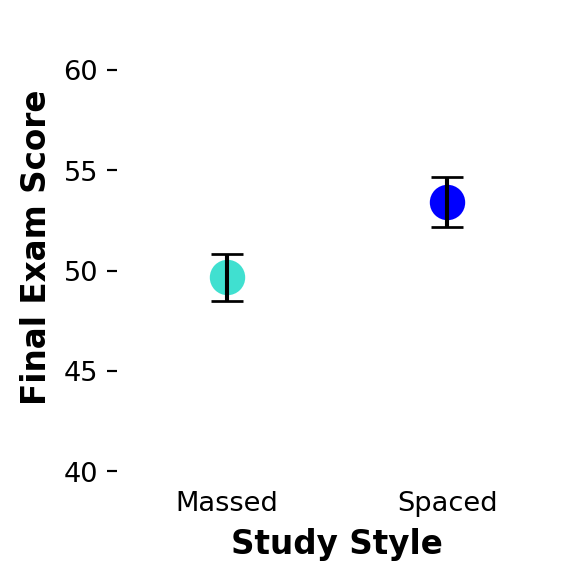

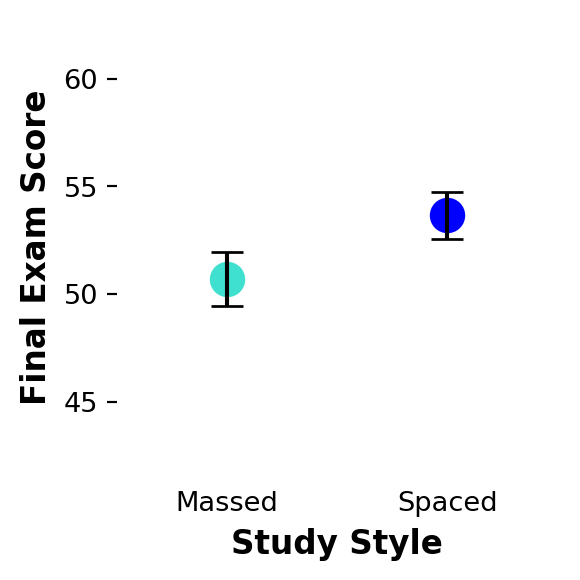

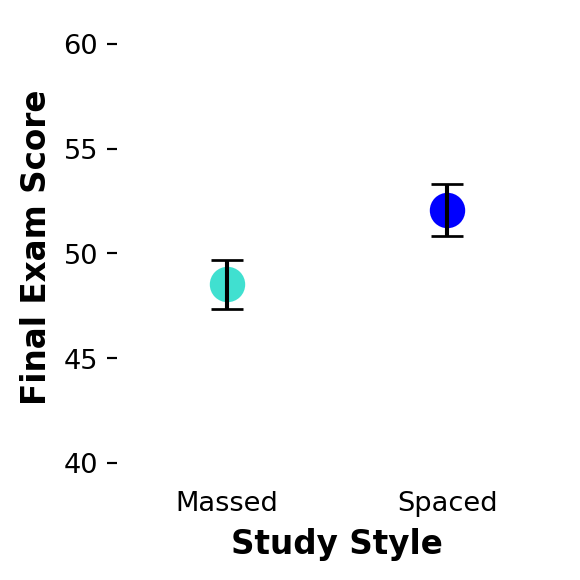

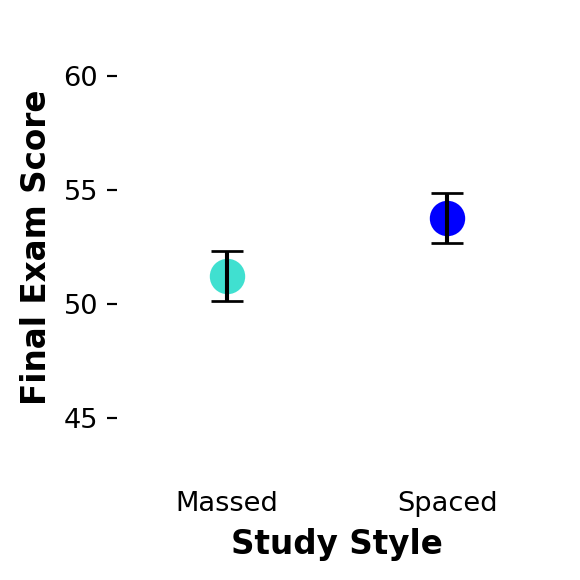

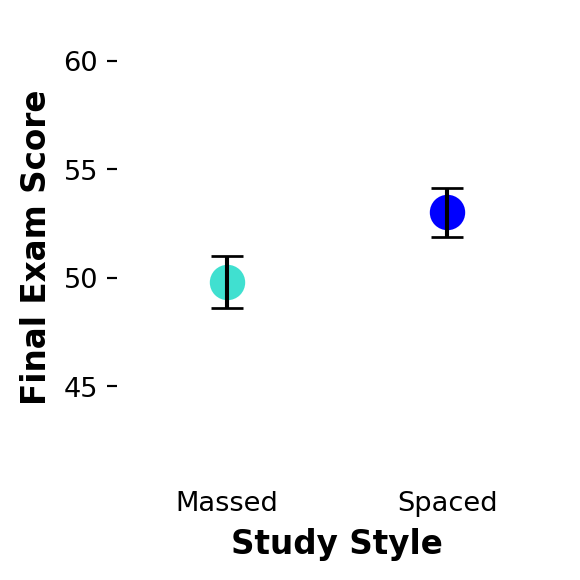

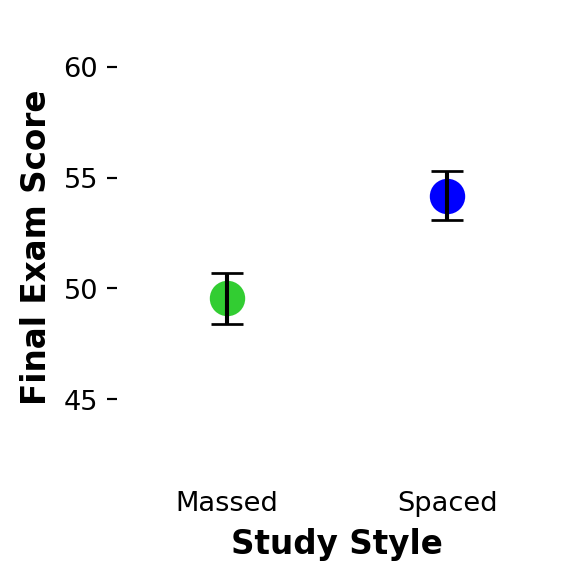

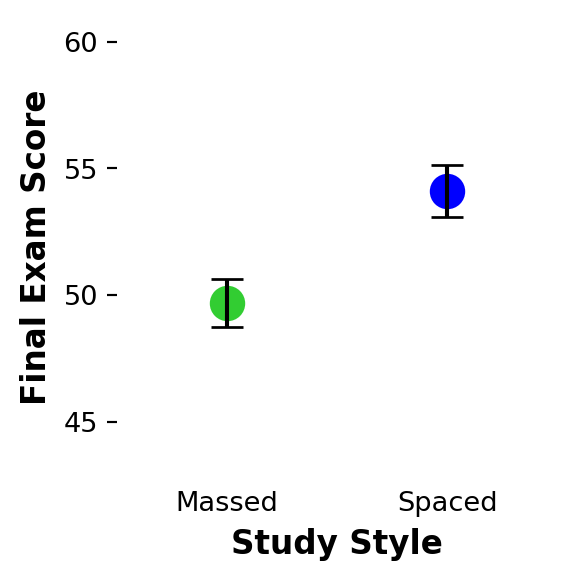

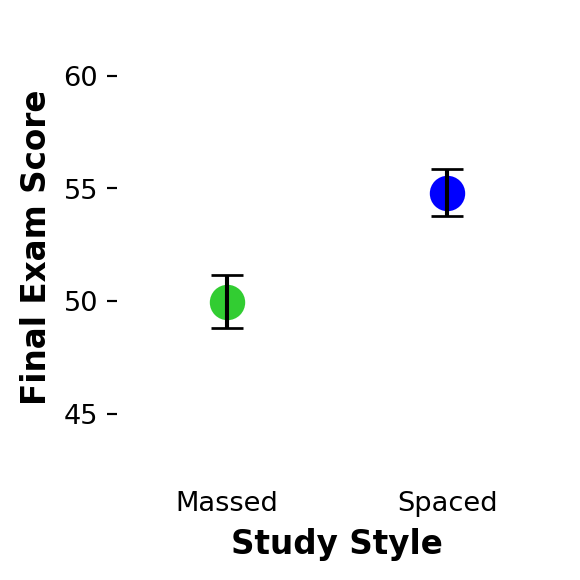

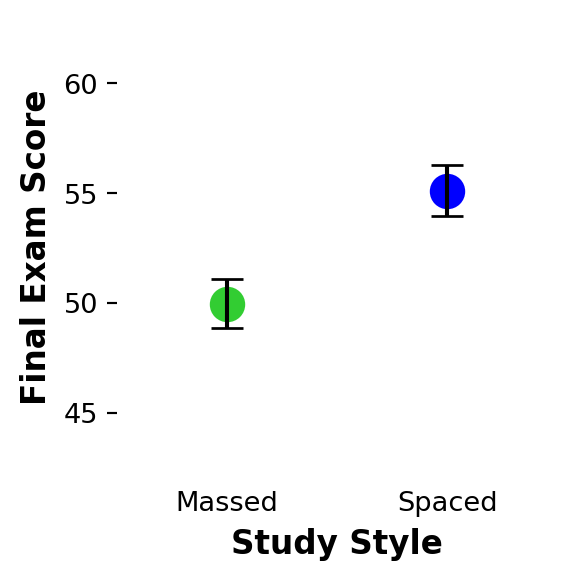

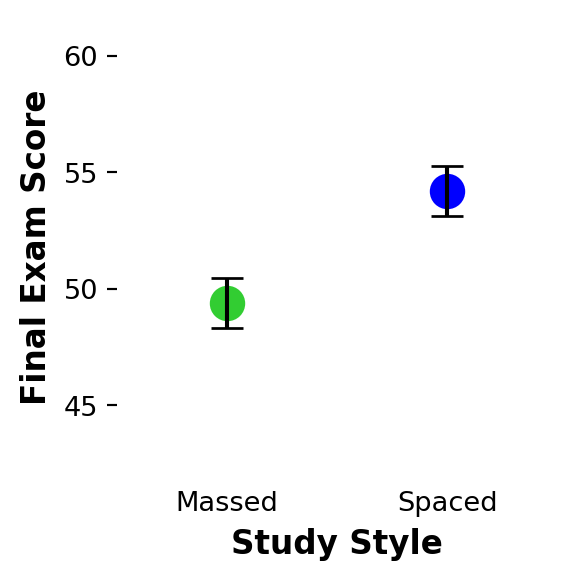

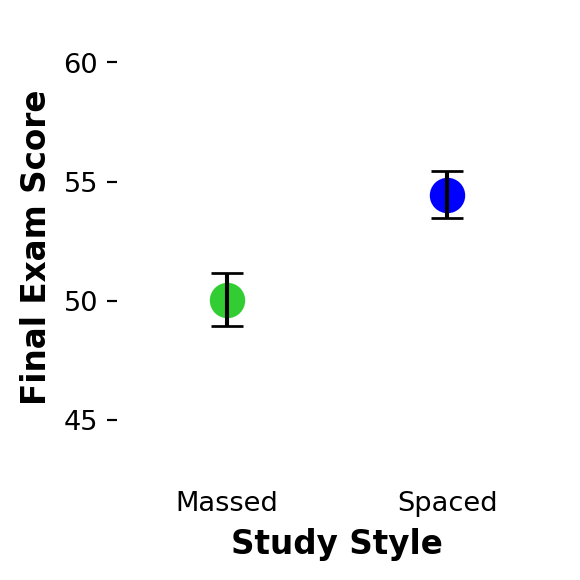

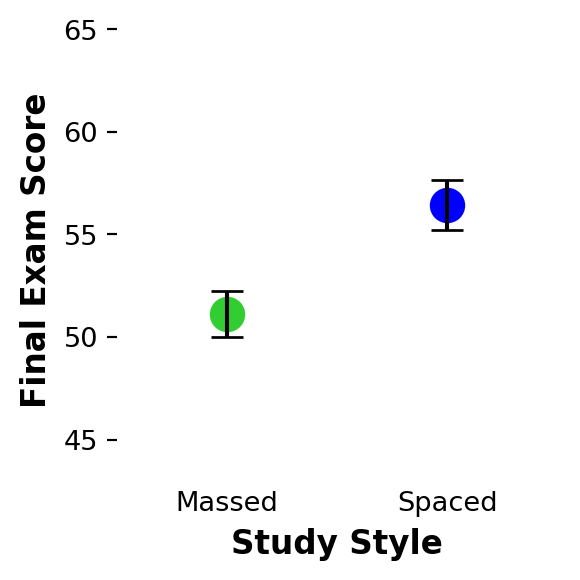

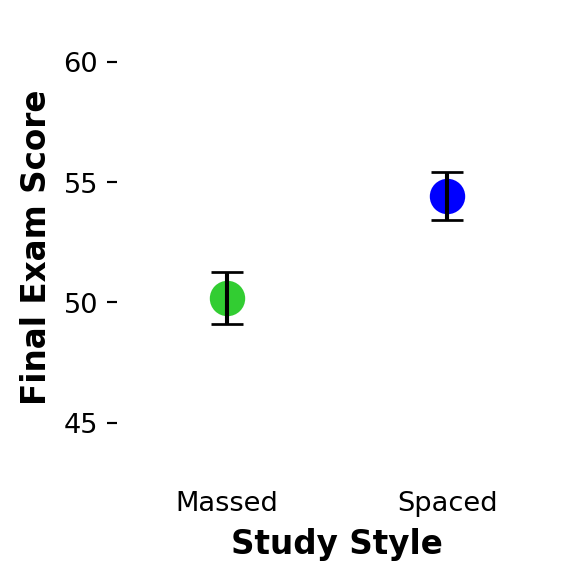

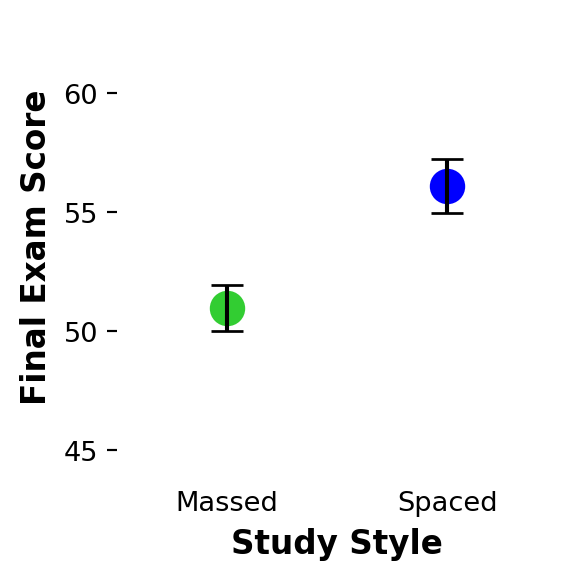

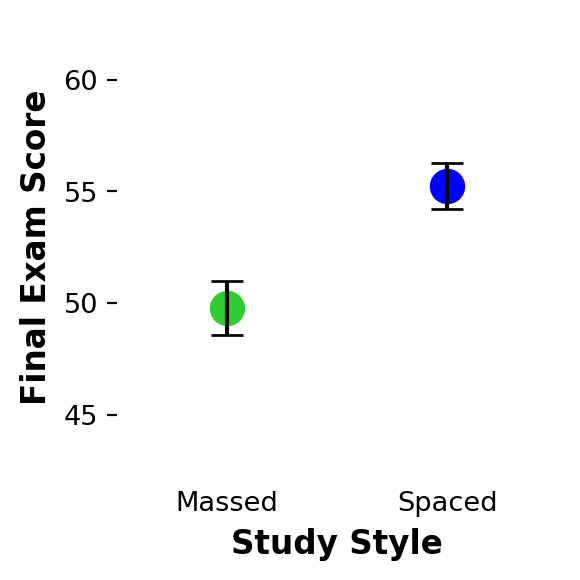

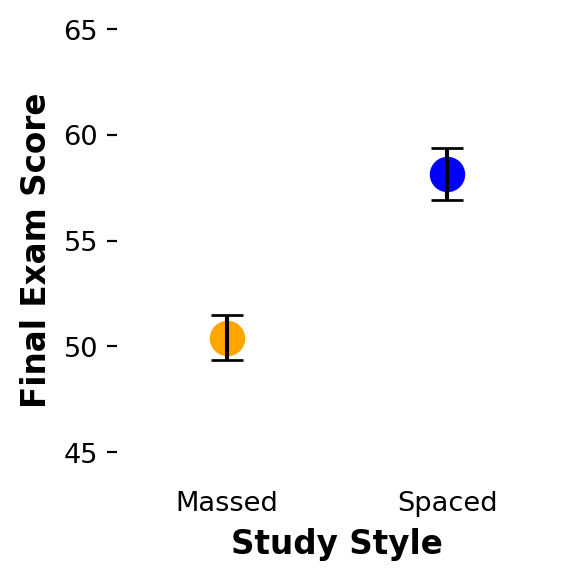

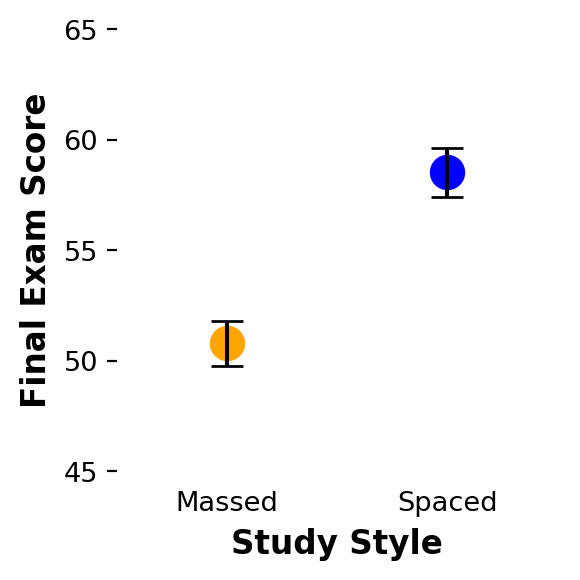

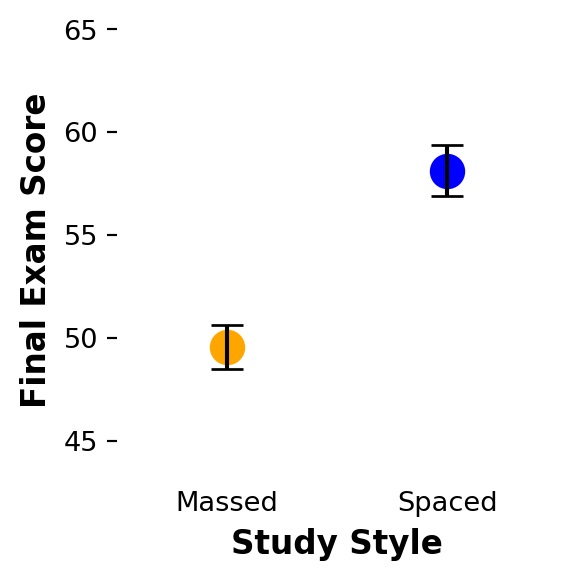

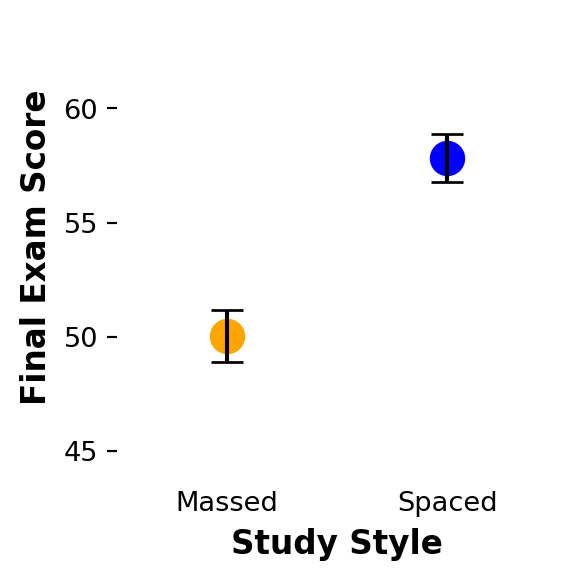

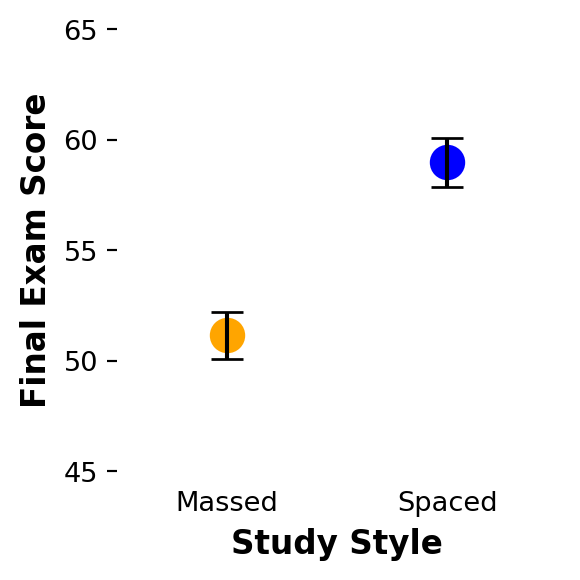

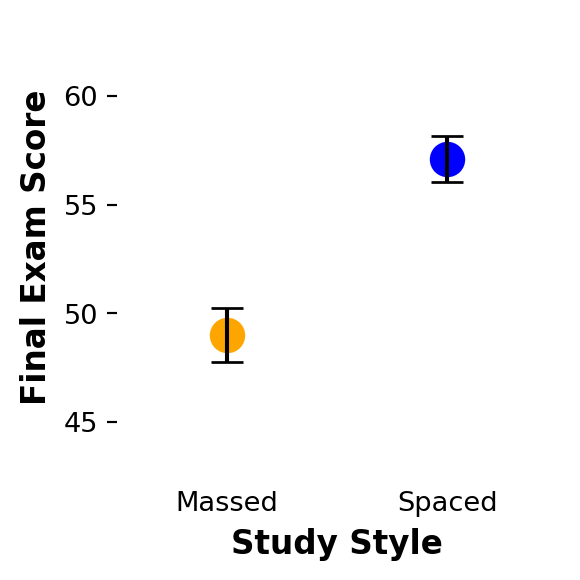

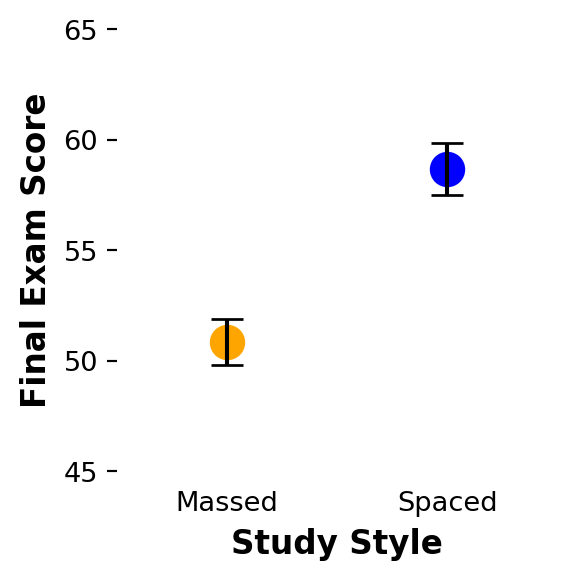

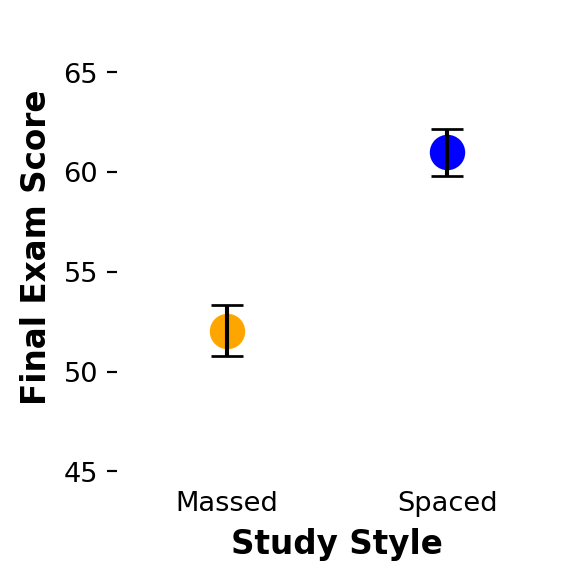

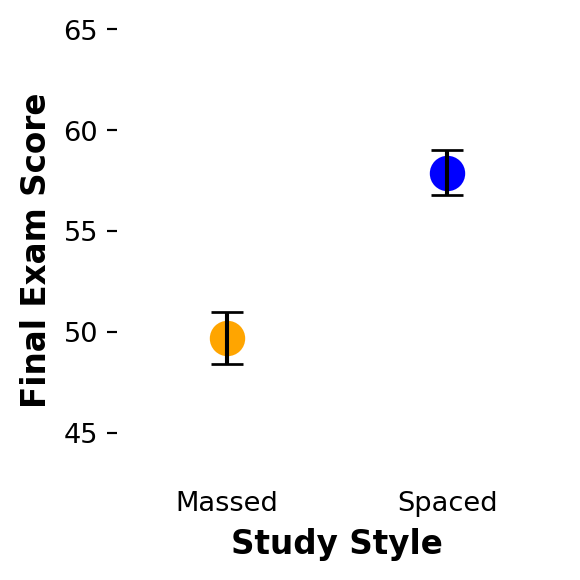

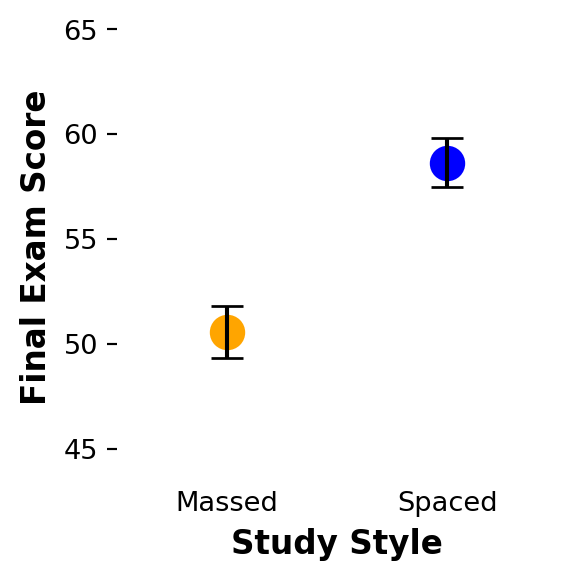

In [12]:
for n in grp2['graphNum']:
    plot_group(n)